In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, GLM
# import PyPlot; const plt = PyPlot ;

In [3]:
validation_data_saft_vr_mie = CSV.read("saft_vr_mie_validation_data.csv",DataFrame)
num_rows = nrow(validation_data_saft_vr_mie)

rename!(validation_data_saft_vr_mie,:sat_t_K_clapeyron=>:sat_temp_strings, :sat_p_MPa_clapeyron=>:sat_pressure_strings,
        :sat_vliq_m3_per_mol_clapeyron=>:sat_vol_liq_strings,:sat_vvap_m3_per_mol_clapeyron=>:sat_vol_vap_strings)

# Define the column names
array_cols_to_create = [:sat_t_K_clapeyron, :sat_p_MPa_clapeyron, :sat_vliq_m3_per_mol_clapeyron, :sat_vvap_m3_per_mol_clapeyron]
string_columns = [:sat_temp_strings, :sat_pressure_strings, :sat_vol_liq_strings, :sat_vol_vap_strings]

# Initialize the columns with zeros
for col in array_cols_to_create
    validation_data_saft_vr_mie[!, col] .= fill([0.0], num_rows)
end

# Process and assign the values to the DataFrame
for (col, str_col) in zip(array_cols_to_create, string_columns)
    for i = 1:num_rows
        string_sq_brackets_removed = replace(validation_data_saft_vr_mie[i, str_col], r"[][]" => "")
        vector_of_floats = [parse(Float64, val) for val in split(string_sq_brackets_removed, ",")]
        validation_data_saft_vr_mie[i, col] = vector_of_floats
    end
end

# Remove the string columns
select!(validation_data_saft_vr_mie, Not(string_columns...));

validation_data_saft_vr_mie;

In [5]:
# # Define the custom order of values
# custom_order = Dict("Methane" => 1, "Value2" => 2, "Value3" => 3, "Value4" => 4)

# # Create a comparison function based on the custom order
# function custom_compare(x, y)
#     return custom_order[x] < custom_order[y]
# end

# # Sort the DataFrame based on the custom comparison function
# sort!(df, :column_to_sort, lt=custom_compare)

# # Display the sorted DataFrame
# println(df)

In [4]:
# Species to filter
species_to_filter = ["methane", "ethane","n-propane","n-butane","n-pentane","n-hexane","n-heptane","n-octane","n-nonane","n-decane"]

# Filter based on species
validation_data_saft_vr_mie_linear_alkanes = filter(row -> lowercase(row.species) in species_to_filter, validation_data_saft_vr_mie) ;


In [5]:
validation_data_saft_vr_mie_linear_alkanes;

In [9]:
function r_squared(y_actual, y_predicted)
    mean_actual = sum(y_actual)/length(y_actual)
    total_ss = sum((y_actual .- mean_actual).^2)
    residual_ss = sum((y_actual .- y_predicted).^2)
    r2 = 1.0 - residual_ss / total_ss
    return r2
end

m_sigmacubed = []
m_epsilon = []
m_vdwas = []

ideal_Mw = collect(range(0,200))
linear_alkanes_Mw = validation_data_saft_vr_mie_linear_alkanes.Mw

for (a, b) in zip(validation_data_saft_vr_mie_linear_alkanes.segment, validation_data_saft_vr_mie_linear_alkanes.sigma)
    push!(m_sigmacubed, a*b^3)
end

for (a, b) in zip(validation_data_saft_vr_mie_linear_alkanes.segment, validation_data_saft_vr_mie_linear_alkanes.epsilon)
    push!(m_epsilon, a*b)
end

for (m, σ, ϵ, λ_r, λ_a, ) in zip(validation_data_saft_vr_mie_linear_alkanes.segment, validation_data_saft_vr_mie_linear_alkanes.sigma, validation_data_saft_vr_mie_linear_alkanes.epsilon, validation_data_saft_vr_mie_linear_alkanes.lambda_r, validation_data_saft_vr_mie_linear_alkanes.lambda_a)
    # vdw_a = -2*pi * ((λ_r/(λ_r - λ_a))*(λ_r/λ_a)^(λ_a/(λ_r-λ_a))) * (ϵ * σ^3 * m * (1/(λ_r - 3) - 1/(λ_a-3)))
    vdw_a = -2*pi * ((λ_r/(λ_r - λ_a))*(λ_r/λ_a)^(λ_a/(λ_r-λ_a))) * (ϵ * σ^3 * m * (1/(λ_r - 3) - 1/(λ_a-3)))

    push!(m_vdwas, vdw_a)
end

lin_fit_coeff_mvdwa = coef(lm(@formula(m_vdwas ~ linear_alkanes_Mw), DataFrame(linear_alkanes_Mw = Float64.(linear_alkanes_Mw),m_vdwas = Float64.(m_vdwas))))
lin_fit_coeff_mσ3 = coef(lm(@formula(m_sigmacubed ~ linear_alkanes_Mw), DataFrame(linear_alkanes_Mw = Float64.(linear_alkanes_Mw),m_sigmacubed = Float64.(m_sigmacubed))))
lin_fit_coeff_mϵ = coef(lm(@formula(m_epsilon ~ linear_alkanes_Mw), DataFrame(linear_alkanes_Mw = Float64.(linear_alkanes_Mw),m_epsilon = Float64.(m_epsilon))));

ideal_mvdwa = [lin_fit_coeff_mvdwa[1] + lin_fit_coeff_mvdwa[2]*i for i in ideal_Mw]
ideal_mσ3 = [lin_fit_coeff_mσ3[1] + lin_fit_coeff_mσ3[2]*i for i in ideal_Mw]
ideal_mϵ = [lin_fit_coeff_mϵ[1] + lin_fit_coeff_mϵ[2]*i for i in ideal_Mw]

ideal_mvdwa_for_r2 = [lin_fit_coeff_mvdwa[1] + lin_fit_coeff_mvdwa[2]*i for i in linear_alkanes_Mw]
ideal_mσ3_for_r2 = [lin_fit_coeff_mσ3[1] + lin_fit_coeff_mσ3[2]*i for i in linear_alkanes_Mw]
ideal_mϵ_for_r2 = [lin_fit_coeff_mϵ[1] + lin_fit_coeff_mϵ[2]*i for i in linear_alkanes_Mw] ;

# Compute R^2
r2_mσ3 = r_squared(m_sigmacubed, ideal_mσ3_for_r2)
r2_mϵ = r_squared(m_epsilon, ideal_mϵ_for_r2)
r2_mvdwa = r_squared(m_vdwas, ideal_mvdwa_for_r2)

# Display the result
println(lin_fit_coeff_mσ3)
println("R\$^2\$ value mσ3: ", r2_mσ3)

println(lin_fit_coeff_mϵ)
println("R\$^2\$ value mϵ: ", r2_mϵ)

println(lin_fit_coeff_mvdwa)
println("R\$^2\$ value mϵ: ", r2_mvdwa)

[18.2780770070087, 1.8975128069907474]
R$^2$ value mσ3: 0.9996083045458773
[36.24515843345274, 8.203422340681593]
R$^2$ value mϵ: 0.9995066114384469
[-25018.32723534692, 3601.3586533380026]
R$^2$ value mϵ: 0.9987562633231497


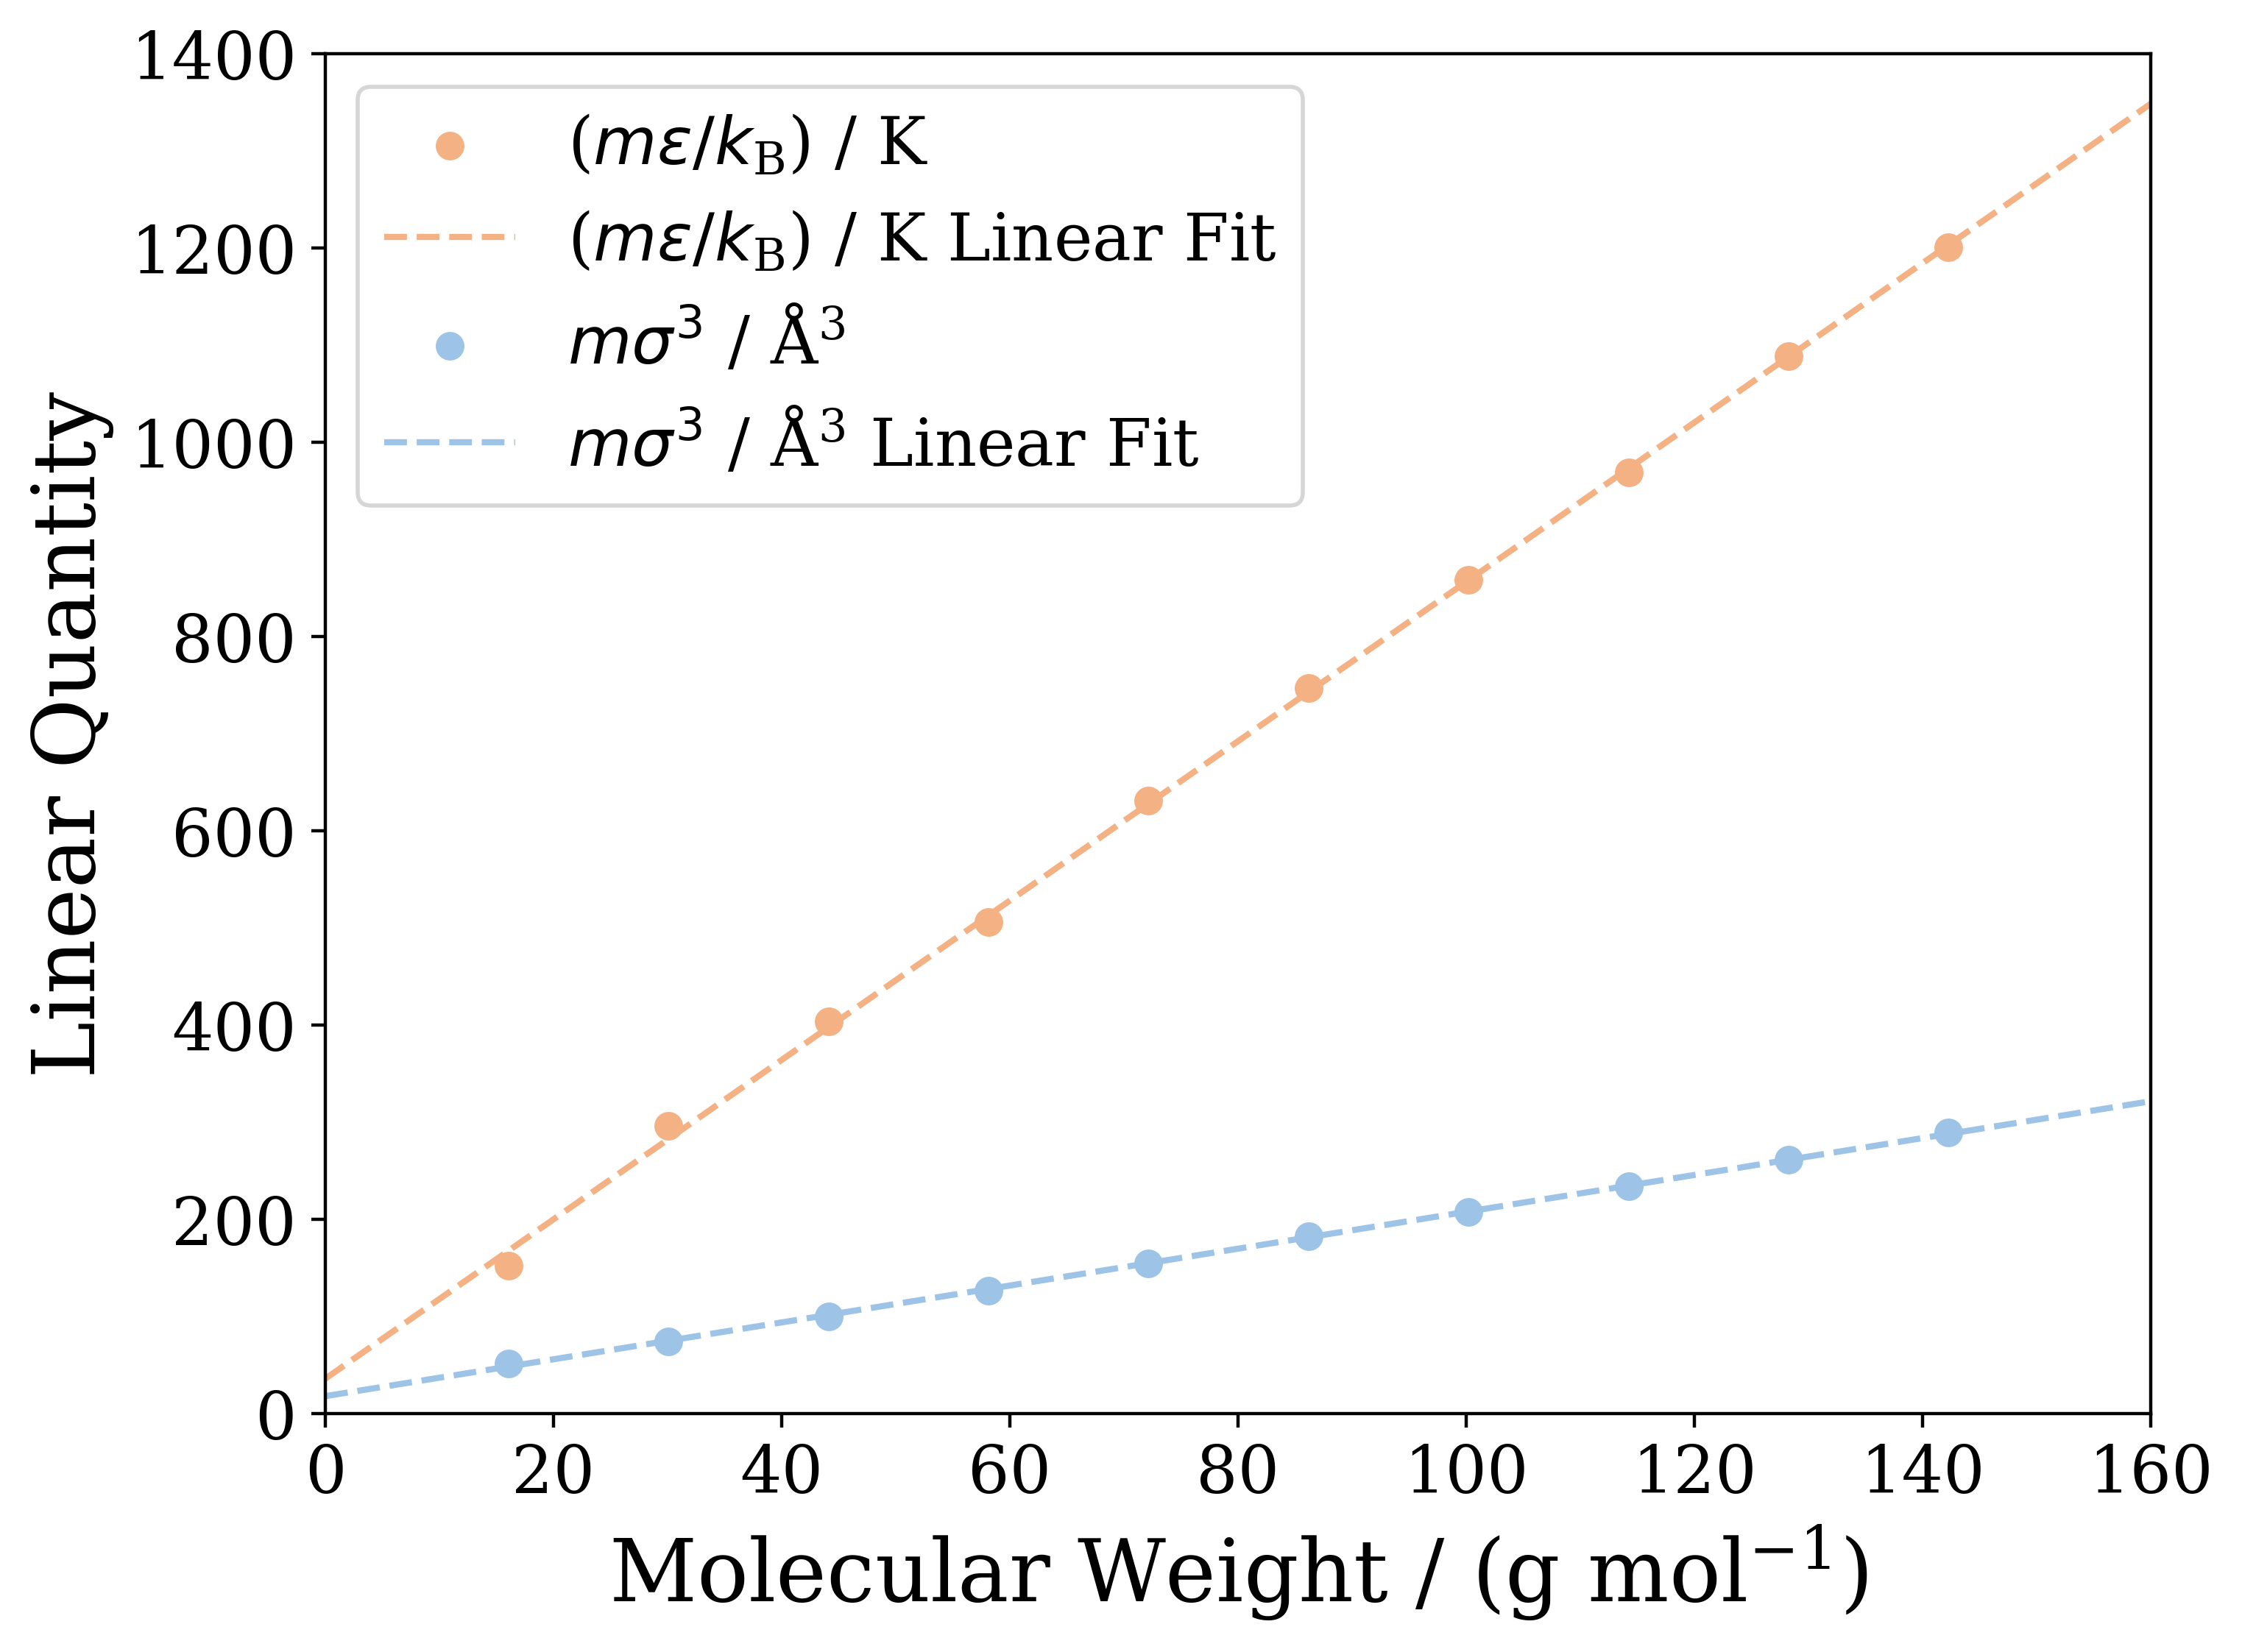

(0.0, 1400.0)

In [8]:
using PyPlot

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=16)

plt.figure(figsize=(8, 6), dpi=400)

colour1 = "#F4B183"
colour2 = "#9DC3E6"

plt.scatter(linear_alkanes_Mw, m_epsilon, label="mε",color=colour1)
plt.plot(ideal_Mw, ideal_mϵ,"--",color=colour1)
plt.scatter(linear_alkanes_Mw, m_sigmacubed, label="mσ^3",color=colour2)
plt.plot(ideal_Mw, ideal_mσ3,"--",color=colour2)

plt.xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)", fontsize=21, fontfamily="serif")
plt.ylabel("Linear Quantity",fontsize = 21,font="serif")
plt.legend([L"($mε/k\mathregular{_B}$) / K",L"($mε/k\mathregular{_B}$) / K Linear Fit",
            L"$mσ^3$ / $\mathregular{Å^3}$",L"$mσ^3$ / $\mathregular{Å^3}$ Linear Fit"],loc="upper left")

# plt.title("Linear Alkane SAFT-VR Mie Parameter Combinations",fontsize=14)
plt.xlim(0,160)
plt.ylim(0,1400);

# plt.savefig("Linear_Quantities_SAFT_VR_Mie.svg")

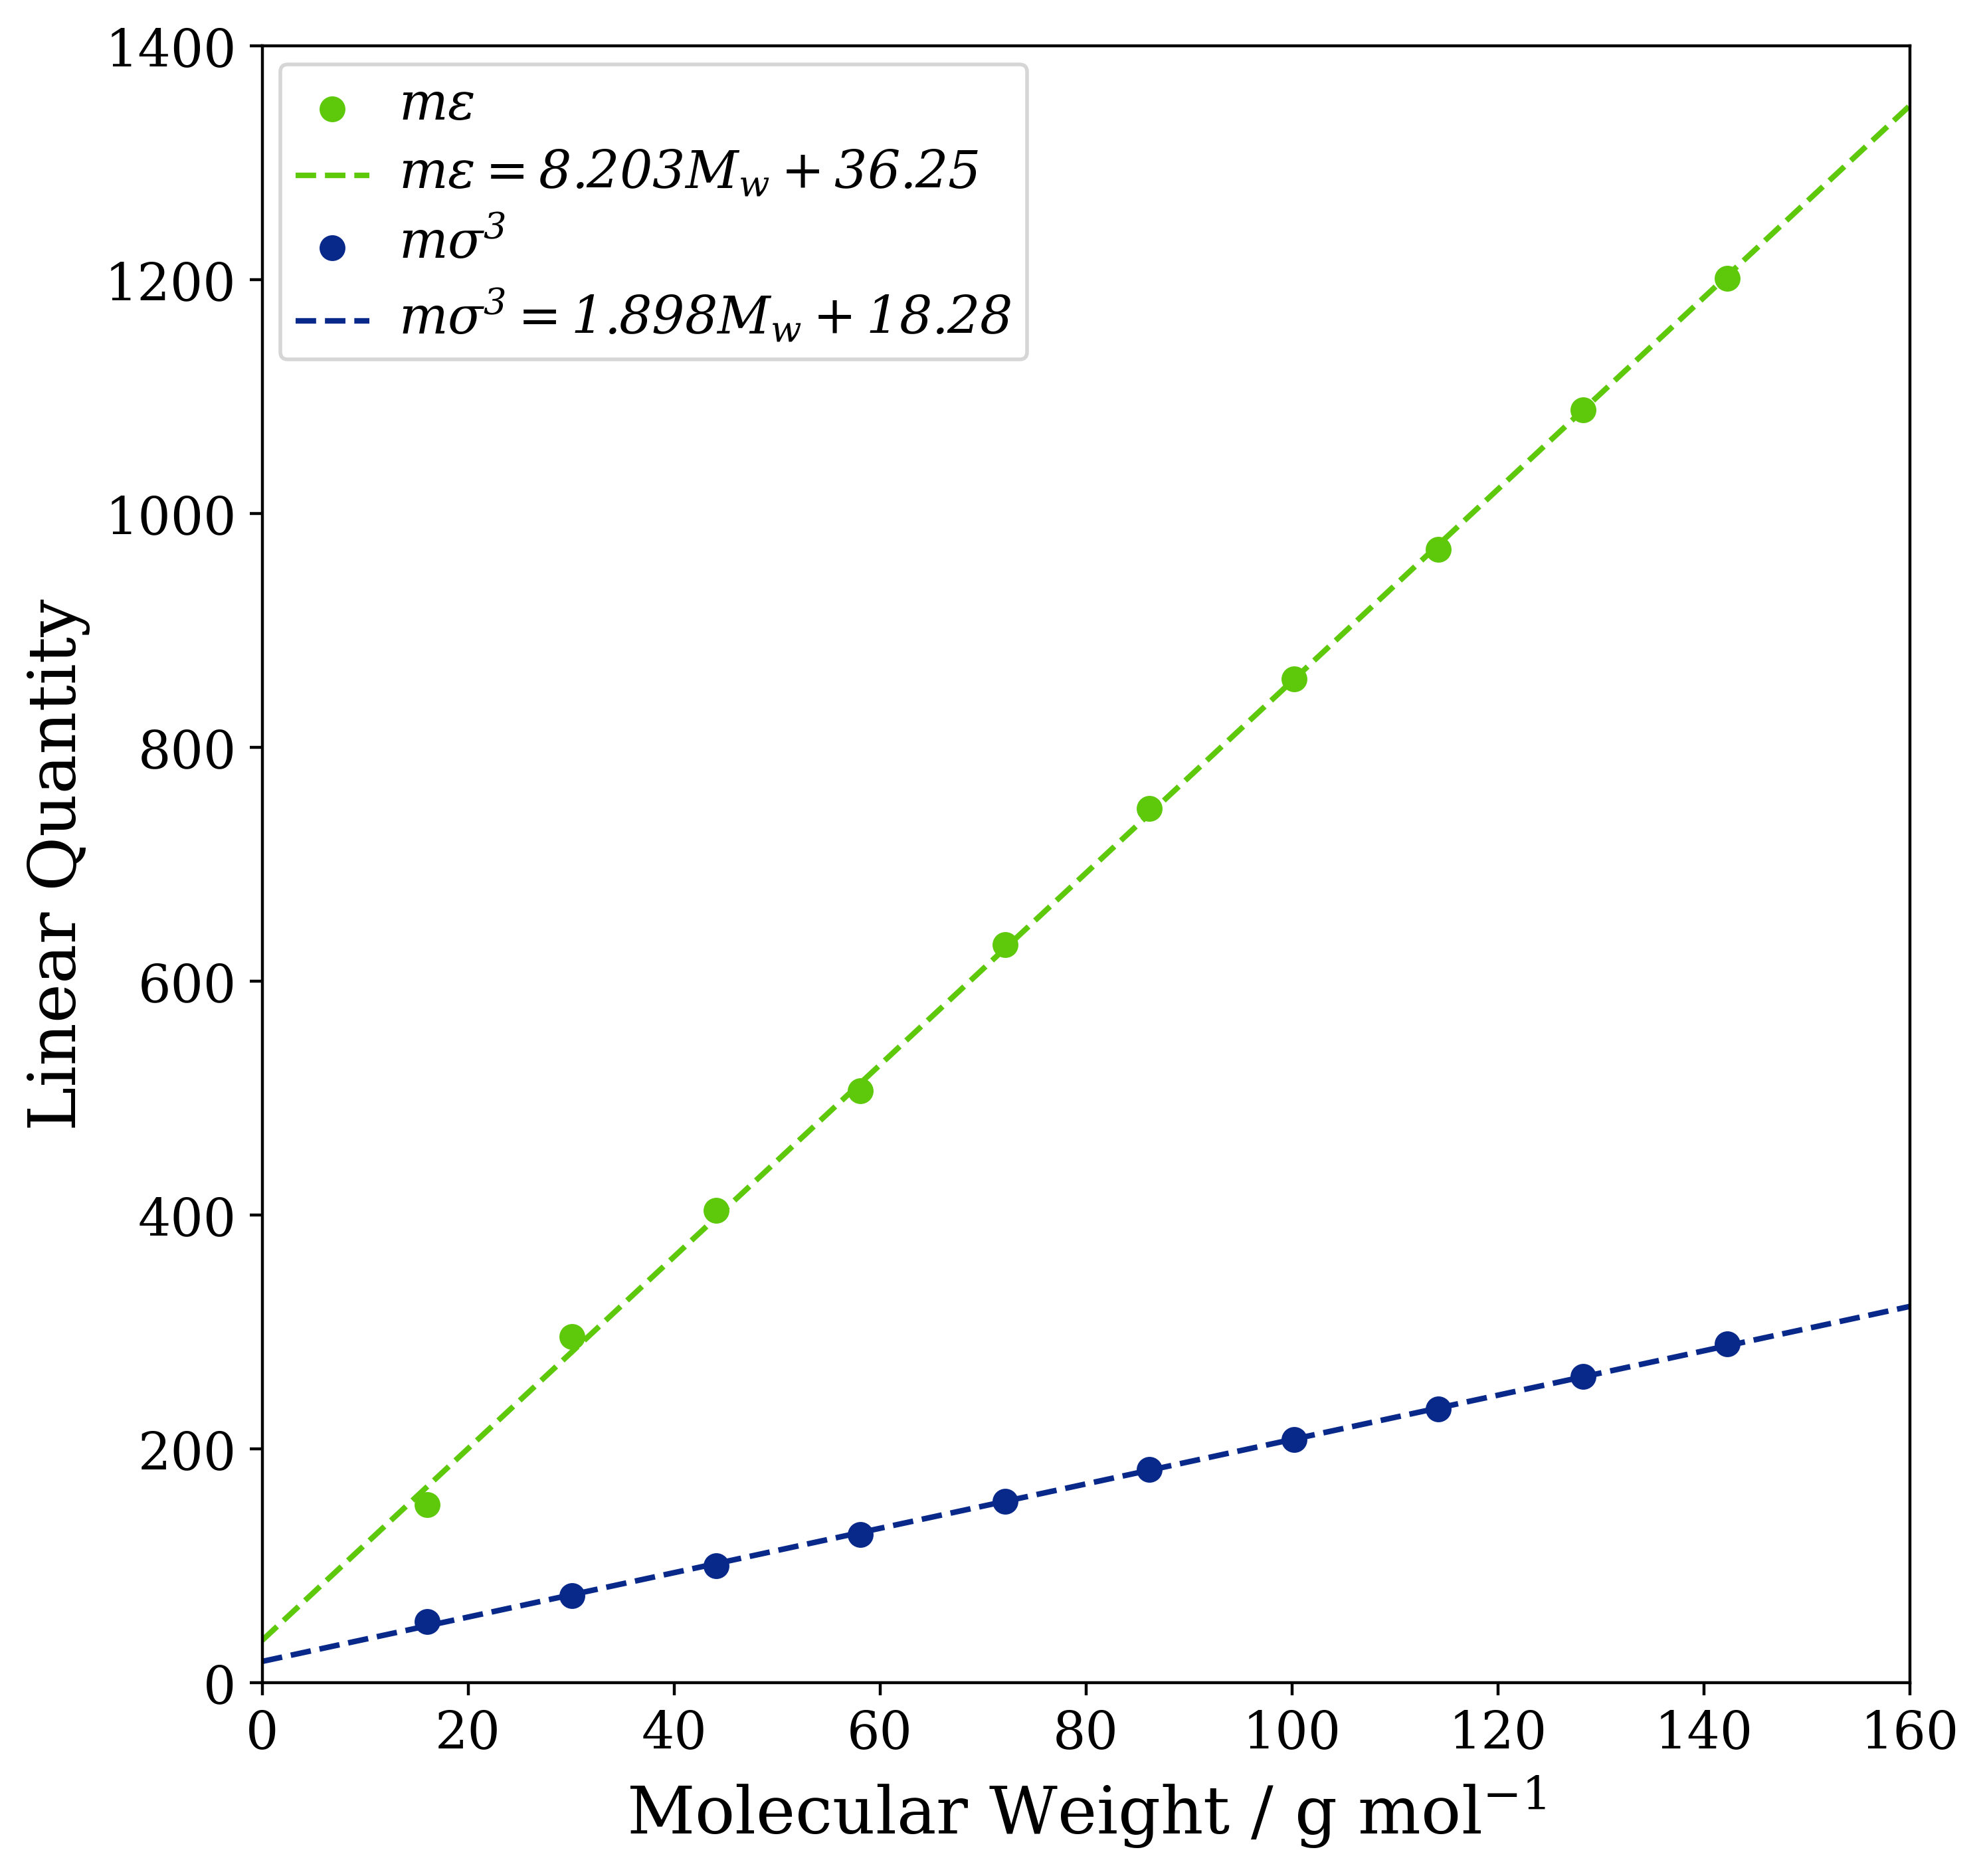

In [110]:
using PyPlot


matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif")

# Your plotting code here

plt.figure(figsize=(8, 8), dpi=400)
font_prop = matplotlib.font_manager.FontProperties(family="DejaVu Serif", style="italic")

plt.scatter(linear_alkanes_Mw, m_epsilon, label=L"$\it{\mathregular{mε}}$", color="#5dc90a")
plt.plot(ideal_Mw, ideal_mϵ, "--", color="#5dc90a", label=L"$\mathit{\mathregular{mε = 8.203M_w + 36.25}}$")
plt.scatter(linear_alkanes_Mw, m_sigmacubed, label=L"$\it{\mathregular{mσ^3}}$", color="#08298a")
plt.plot(ideal_Mw, ideal_mσ3, "--", color="#08298a", label=L"$\mathit{\mathregular{mσ^3 = 1.898M_w + 18.28}}$")

# plt.xlabel("Molecular Weight (\$M_w\$) / g mol\$^{-1}\$", fontsize=18, fontfamily="serif")
plt.xlabel(L"Molecular Weight / g mol$\mathregular{^{-1}}$", fontsize=18, fontfamily="serif")
plt.ylabel("Linear Quantity", fontsize=18, fontfamily="serif")
plt.legend(loc="upper left",fontsize=14)
plt.xticks(fontsize=14, fontfamily="serif")
plt.yticks(fontsize=14, fontfamily="serif")

plt.xlim(0, 160)
plt.ylim(0, 1400)

# Get legend texts
legend_texts = plt.legend().get_texts()

# Set font properties for the legend text
font_prop = matplotlib.font_manager.FontProperties(family="DejaVu Serif", style="italic",size=14)
if !isempty(legend_texts)
    for legend_text in legend_texts
        setp(legend_text, fontproperties=font_prop)
    end
end


# plt.title("Linear Alkane SAFT-VR Mie Parameter Combinations", fontsize=14)
# plt.savefig("Linear_Quantities_SAFT_VR_Mie.svg")

plt.show()


In [109]:
using PyPlot

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif")

# Your plotting code here

plt.figure(figsize=(8, 8), dpi=400)

plt.scatter(linear_alkanes_Mw, m_epsilon, label=L"$\it{\mathregular{mε}}$", color="#5dc90a")
plt.plot(ideal_Mw, ideal_mϵ, "--", color="#5dc90a", label=L"$\mathit{\mathregular{mε = 8.203M_w + 36.25}}$")
plt.scatter(linear_alkanes_Mw, m_sigmacubed, label=L"$\it{\mathregular{mσ^3}}$", color="#08298a")
plt.plot(ideal_Mw, ideal_mσ3, "--", color="#08298a", label=L"$\mathit{\mathregular{mσ^3 = 1.898M_w + 18.28}}$")

# Set font properties for xlabel using LaTeX expression
plt.xlabel(L"Molecular Weight ($\text{\fontfamily{DejaVu Serif}\textit{M}}_{\text{\fontfamily{DejaVu Serif}\textit{w}}}$) / g mol$\mathregular{^{-1}}$", fontsize=18, fontfamily="serif")

plt.ylabel("Linear Quantity", fontsize=18, fontfamily="serif")
plt.legend(loc="upper left", fontsize=14)

# Set font properties for the legend text
legend_texts = plt.legend().get_texts()
font_prop = matplotlib.font_manager.FontProperties(family="DejaVu Serif", style="italic", size=14)
for legend_text in legend_texts
    setp(legend_text, fontproperties=font_prop)
end

plt.xticks(fontsize=14, fontfamily="serif")
plt.yticks(fontsize=14, fontfamily="serif")

plt.xlim(0, 160)
plt.ylim(0, 1400)

plt.show()


Figure(PyObject <Figure size 3200x3200 with 1 Axes>)

Font 'rm' does not have a glyph for '\x0c' [U+c], substituting with a dummy symbol.


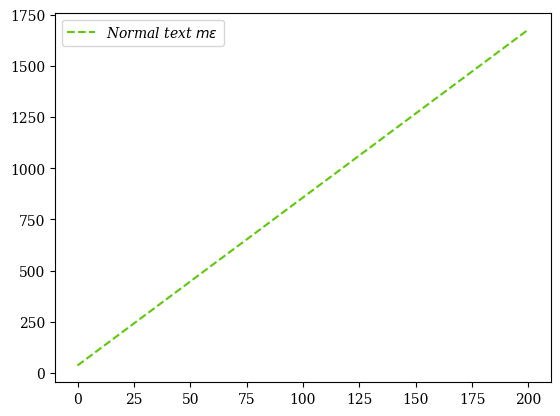

In [88]:
using PyPlot
using LaTeXStrings

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif")

# Your plotting code here

normal_text = "Normal text"
italic_text = L"$\mathit{mε}$"
combined_label = LaTeXString(normal_text * " " * italic_text)

plt.plot(ideal_Mw, ideal_mϵ, "--", color="#5dc90a", label=combined_label)

# Get legend texts
legend_texts = plt.legend().get_texts()

# Set font properties for the entire legend text
font_prop = matplotlib.font_manager.FontProperties(family="DejaVu Serif", style="italic")
if !isempty(legend_texts)
    setp(legend_texts[1], label=combined_label, fontproperties=font_prop)
end

plt.show()
